In [5]:
from collections import defaultdict, Counter, namedtuple
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
import random
import copy

In [202]:
chrom = '22'
#start_pos, end_pos = 17900000, 25900000
#start_pos, end_pos = 17037000, 20122000
#start_pos, end_pos = 16900000, 26900000
start_pos, end_pos = 17879890, 25895967 # from omim (liftover to hg19)

ihart_family_sizes = [3, 4, 5, 6]
ihart_phase_dir = '../phased_ihart'
ssc_family_sizes = [3, 4]
ssc_phase_dir = '../phased_ssc'

In [203]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

# Filter Families


In [204]:
family_to_individuals = dict()

def load_families(phase_dir, family_sizes):
    family_to_chroms = defaultdict(set)
    
    print(chrom, end=' ')

    for j in family_sizes:
        try:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    family_to_chroms[family_key].add(chrom)
                    family_to_individuals[family_key] = pieces[1:(1+j)]
        except FileNotFoundError:
            print('File not found', 'chrom', chrom, 'family size', j)
        except StopIteration:
            print('File empty', 'chrom', chrom, 'family size', j)

    families_to_include = set(family_to_chroms.keys())
    print('Families with all chroms', len(families_to_include))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    return families_to_include
ihart_families = load_families(ihart_phase_dir, ihart_family_sizes)
ssc_families = load_families(ssc_phase_dir, ssc_family_sizes)

22 Families with all chroms 871
Counter({1: 871})
22 Families with all chroms 519
Counter({1: 519})


In [205]:
ihart_individuals = sorted(sum([family_to_individuals[k] for k in ihart_families], []))
ihart_ind_to_index = dict([(x, i) for i, x in enumerate(ihart_individuals)])
ssc_individuals = sorted(sum([family_to_individuals[k] for k in ssc_families], []))
ssc_ind_to_index = dict([(x, i) for i, x in enumerate(ssc_individuals)])

# Read in deletions


In [206]:
Deletion = namedtuple('Deletion', ['family', 'chrom', 'start_pos', 'end_pos', 'length', 'opt_start_pos', 'opt_end_pos', 
                                   'trans', 'notrans', 
                                   'family_size', 'is_mat', 'is_pat', 'state', 'dataset', 'supporting_sites'])



In [207]:
from collections import defaultdict

def read_deletions(chrom, phase_dir, family_sizes, families, dataset):
    deletions = []

    for j in family_sizes:
            
        # load deletions
        family_to_states = defaultdict(list)
        family_to_pos = defaultdict(list)
        family_to_indices = defaultdict(list)
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in families:
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    start_index, end_index = [int(x) for x in pieces[(4+(j*2)):(6+(j*2))]]
                    assert end_pos >= start_pos
                        
                    # if a segment is never inherited, we don't know if it has a deletion or not
                    if state[0] == 0 and state[1] == 0:
                        pass
                    else:
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                            state[0] = -1
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                            state[1] = -1
                    if state[2] == 0 and state[3] == 0:
                        pass
                    else:
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                            state[2] = -1
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                            state[3] = -1

                    family_to_states[family_key].append(state)
                    family_to_pos[family_key].append((start_pos, end_pos))
                    family_to_indices[family_key].append((start_index, end_index))

        # for each family, detect deletion transmission
        for family_key, states in family_to_states.items():
            states = np.asarray(states)
            assert np.all(states[0, :4] != 0)
            assert np.all(states[-1, :4] != 0)
            positions = np.asarray(family_to_pos[family_key])
            pos_indices = np.asarray(family_to_indices[family_key])
            inds = family_to_individuals[family_key]

            # for each ancestral chromosome
            for anc in range(4):
                is_mat = anc==0 or anc==1
                is_pat = anc==2 or anc==3
                    
                start_indices = np.where((states[:-1, anc] != 0) & (states[1:, anc] == 0))[0]+1
                end_indices = np.where((states[:-1, anc] == 0) & (states[1:, anc] != 0))[0]+1
                for s_ind, e_ind in zip(start_indices, end_indices):
                    
                    # check if parental double deletion
                    if is_mat:
                        is_double = np.all(states[s_ind, :2]==0)
                    else:
                        is_double = np.all(states[s_ind, 2:4]==0)
        
                    # check if recombination event occured and that inheritance state is known
                    has_recomb = False
                    if is_mat:
                        indices = np.arange(4, states.shape[1]-1, 2)
                    else:
                        indices = np.arange(5, states.shape[1]-1, 2)
                        
                    inh_known = np.all(states[s_ind:e_ind, indices] != -1)
                        
                    for i in range(s_ind, e_ind):
                        if np.any(states[i, indices] != states[s_ind, indices]):
                            has_recomb = True
                            
                    # check if in ok region
                    ok_region = np.all(states[s_ind:e_ind, -1] == 0)
                    
                    if ok_region and inh_known and (not has_recomb):
                        start_pos, end_pos = positions[s_ind, 0], positions[e_ind-1, 1]
                        start_pos_index, end_pos_index = pos_indices[s_ind, 0], pos_indices[e_ind-1, 1]
                        
                        # find boundaries of the deletion
                        #print(s_ind, e_ind)
                        opt_start_index = s_ind
                        while states[opt_start_index, anc] != 1 and opt_start_index > 0:
                            opt_start_index -= 1
                        opt_start_pos = positions[opt_start_index+1, 0]
                        
                        opt_end_index = e_ind
                        while(states[opt_end_index, anc]) != 1 and opt_end_index < states.shape[0]-1:
                            opt_end_index += 1
                        opt_end_pos = positions[e_ind-1, 1]
                        
                        assert start_pos <= end_pos
                        assert opt_start_pos <= start_pos
                        assert end_pos <= opt_end_pos
                        
                        state = states[s_ind, :]
                    
                        # children
                        trans, notrans = [], []
                        for k, child in zip(range(2, j), inds[2:]):
                            mom_s, dad_s = state[(2*k):(2*(k+1))]

                            if is_mat:
                                assert mom_s != -1
                                if anc==mom_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)
                            if is_pat:
                                assert dad_s != -1
                                if anc==2+dad_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)

                        if (len(trans) + len(notrans) == j-2) and (len(trans) > 0):
                            deletions.append(Deletion(family_key, chrom, start_pos, end_pos, end_pos-start_pos+1,
                                                      opt_start_pos, opt_end_pos,
                                                              tuple(trans), tuple(notrans), j, is_mat, is_pat,
                                                              tuple(states[s_ind, :]), dataset,
                                                    end_pos_index-start_pos_index+1))
                        
    # sort deletions
    deletions = sorted(deletions, key=lambda x: x.start_pos)
    return deletions



In [208]:
class DeletionCollection:
    def __init__(self, deletion, matches):
        self.deletion = deletion
        self.matches = matches

def create_collections(deletions):
    collections = []
    
    starts = np.array([d.start_pos for d in deletions])
    stops = np.array([d.end_pos for d in deletions])

    ordered_start_indices = np.argsort(starts)
    ordered_starts = starts[ordered_start_indices]
    ordered_stop_indices = np.argsort(stops)
    ordered_stops = stops[ordered_stop_indices]
        
    insert_starts_in_stops = np.searchsorted(ordered_stops, starts)
    insert_stops_in_starts = np.searchsorted(ordered_starts, stops, side='right')
        
    indices = np.ones((len(deletions),), dtype=bool)

    for del_index, main_d in enumerate(deletions):
        indices[:] = True
        indices[ordered_stop_indices[:insert_starts_in_stops[del_index]]] = False
        indices[ordered_start_indices[insert_stops_in_starts[del_index]:]] = False

        collections.append(DeletionCollection(main_d, [deletions[j] for j in np.where(indices)[0]]))
    return collections



In [209]:
def prune_deletions(collections, share_cutoff=0.8):    
    # first, prune deletions that don't overlap with the main deletion by share_cutoff
    for c in collections:
        lengths = np.array([d.length for d in c.matches])
        overlaps1 = np.array([min(d.opt_end_pos, c.deletion.end_pos)-max(d.opt_start_pos, c.deletion.start_pos)+1 for d in c.matches])
        overlaps2 = np.array([min(d.end_pos, c.deletion.opt_end_pos)-max(d.start_pos, c.deletion.opt_start_pos)+1 for d in c.matches])
        c.matches = set([c.matches[j] for j in np.where((overlaps2 >= 0) & (overlaps1 >= share_cutoff*c.deletion.length))[0]])
    return collections

def prune_collections(collections):
        
    deletion_to_index = dict([(x.deletion, i) for i, x in enumerate(collections)])
    
    # now, get rid of collections that are identical to other collections
    for c in collections:
        if c is not None:
            for d in c.matches:
                index = deletion_to_index[d]
                if (c.deletion != d) and (collections[index] is not None) and (c.matches == collections[index].matches):
                    collections[index] = None
    #print('removing %d of %d' % (len([x for x in collections if x is None]), len(collections)))
    collections = [x for x in collections if x is not None]
    return collections





In [210]:
print(chrom, end=' ')
    
ihart_deletions = [x for x in read_deletions(chrom, ihart_phase_dir, ihart_family_sizes, ihart_families, 'iHART') if x.start_pos >= start_pos and x.end_pos <= end_pos]
print('id', end=' ')
    
ssc_deletions = [x for x in read_deletions(chrom, ssc_phase_dir, ssc_family_sizes, ssc_families, 'SSC') if x.start_pos >= start_pos and x.end_pos <= end_pos]
print('sd', end=' ')
    
deletions = sorted(ihart_deletions + ssc_deletions, key=lambda x: x.start_pos)
collections = create_collections(deletions)
print('c', end=' ')
    
collections = prune_deletions(collections)
print('p', end=' ')
    
collections = prune_collections(collections)
print(len(collections))
        

22 id sd c p 355


In [211]:
individuals = sorted(set(sum([list(d.trans)+list(d.notrans) for d in deletions], [])))
ind_to_index = dict((x, i) for i, x in enumerate(individuals))
sites = sorted(set(sum([[d.start_pos-1, d.start_pos, d.start_pos+1, d.end_pos-1, d.end_pos, d.end_pos+1] for d in deletions], [])))
site_to_index = dict((x, i) for i, x in enumerate(sites))
block = np.zeros((len(individuals), len(sites)), dtype=np.int8)

for d in deletions:
    for x in d.trans:
        block[ind_to_index[x], site_to_index[d.start_pos]:site_to_index[d.end_pos+1]] = 1
    for x in d.notrans:
        block[ind_to_index[x], site_to_index[d.start_pos]:site_to_index[d.end_pos+1]] = -1

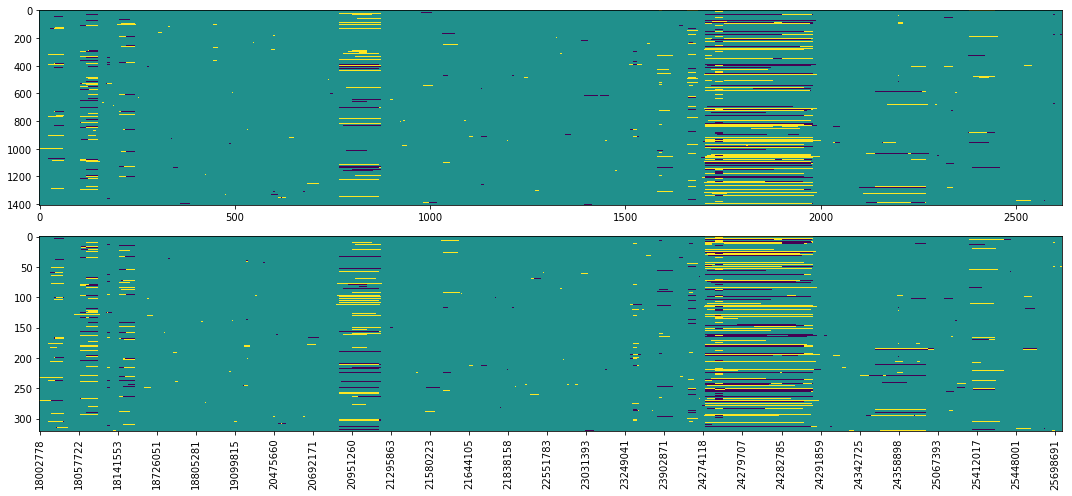

In [242]:
autism_indices = np.array([child_id_to_affected[x]=='2' for x in individuals])
ihart_indices = np.array([x in ihart_individuals for x in individuals])

plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.imshow(block[autism_indices & ihart_indices, :], aspect='auto')
plt.subplot(2, 1, 2)
plt.imshow(block[~autism_indices & ihart_indices, :], aspect='auto')

x = range(0, block.shape[1], 100)
plt.xticks(x, [str(sites[i]) for i in x], rotation=90)

plt.tight_layout()
plt.show()

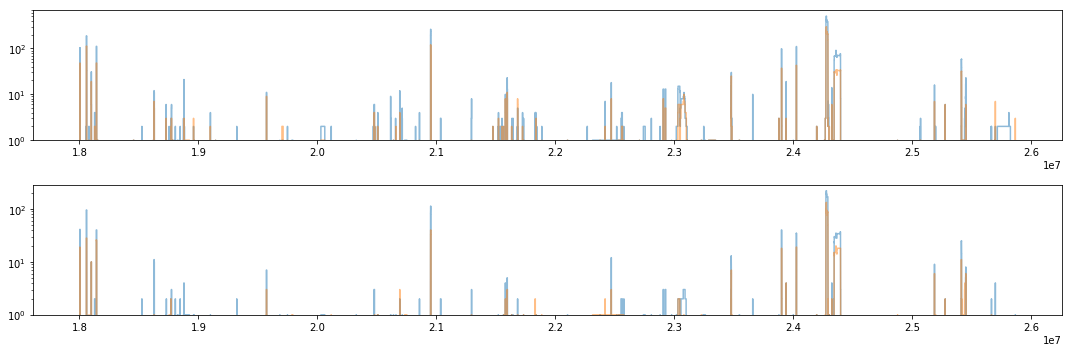

In [213]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
plt.semilogy(sites, np.sum(block[autism_indices, :]==1, axis=0), alpha=0.5)
plt.semilogy(sites, np.sum(block[autism_indices, :]==-1, axis=0), alpha=0.5)
plt.ylim([1, None])

plt.subplot(2, 1, 2)
plt.semilogy(sites, np.sum(block[~autism_indices, :]==1, axis=0), alpha=0.5)
plt.semilogy(sites, np.sum(block[~autism_indices, :]==-1, axis=0), alpha=0.5)
plt.ylim([1, None])

plt.tight_layout()
plt.show()

# Modified TDT

In [214]:
def create_contingency(collections, family_sizes, filter_child, verbose=True):
    # chrom, collection, family_size, notrans/trans
    contingency = np.zeros((len(collections), len(family_sizes), 2))
    familysize_to_index = dict([(x, i) for i, x in enumerate(family_sizes)])
    
    for j, c in enumerate(collections):
        for k, s in enumerate(family_sizes):
            contingency[j, k, 0] = sum([len([x for x in d.notrans if filter_child(x, d.is_mat, d.dataset)]) for d in c.matches if d.family_size==s])
            contingency[j, k, 1] = sum([len([x for x in d.trans if filter_child(x, d.is_mat, d.dataset)]) for d in c.matches if d.family_size==s])
    return contingency

contingency_both_aff = create_contingency(collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and child_id_to_sex[child_id]=='1')
contingency_both_unaff = create_contingency(collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and child_id_to_sex[child_id]=='1')

contingency_ihart_aff = create_contingency(collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and dataset=='iHART' and child_id_to_sex[child_id]=='1')
contingency_ihart_unaff = create_contingency(collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and dataset=='iHART' and child_id_to_sex[child_id]=='1')

contingency_ssc_aff = create_contingency(collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and dataset=='SSC' and child_id_to_sex[child_id]=='1')
contingency_ssc_unaff = create_contingency(collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and dataset=='SSC' and child_id_to_sex[child_id]=='1')



In [239]:
print('iHART')
c = DeletionCollection(None, [d for d in deletions if d.dataset == 'iHART'])
co = create_contingency([c], ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and child_id_to_sex[child_id]=='1')
print(btr.calculate_transmission_rates(co, ihart_family_sizes))
co = create_contingency([c], ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and child_id_to_sex[child_id]=='1')
print(btr.calculate_transmission_rates(co, ihart_family_sizes))

print('SSC')
c = DeletionCollection(None, [d for d in deletions if d.dataset == 'SSC'])
co = create_contingency([c], ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and child_id_to_sex[child_id]=='1')
print(btr.calculate_transmission_rates(co, ihart_family_sizes))
co = create_contingency([c], ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and child_id_to_sex[child_id]=='1')
print(btr.calculate_transmission_rates(co, ihart_family_sizes))

print('Both')
c = DeletionCollection(None, deletions)
co = create_contingency([c], ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and child_id_to_sex[child_id]=='1')
print(btr.calculate_transmission_rates(co, ihart_family_sizes))
co = create_contingency([c], ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and child_id_to_sex[child_id]=='1')
print(btr.calculate_transmission_rates(co, ihart_family_sizes))


iHART
[0.54530907]
[0.54664207]
SSC
[0.51023963]
[0.575]
Both
[0.54101176]
[0.55669262]


In [290]:
import bayesian_transmission_rate as btr
import importlib
importlib.reload(btr)

transrates_both_aff = btr.calculate_transmission_rates(contingency_both_aff, ihart_family_sizes, na_cutoff=0)
transrates_both_unaff = btr.calculate_transmission_rates(contingency_both_unaff, ihart_family_sizes, na_cutoff=0)

transrates_ihart_aff = btr.calculate_transmission_rates(contingency_ihart_aff, ihart_family_sizes, na_cutoff=0)
transrates_ihart_unaff = btr.calculate_transmission_rates(contingency_ihart_unaff, ihart_family_sizes, na_cutoff=0)
              
transrates_ssc_aff = btr.calculate_transmission_rates(contingency_ssc_aff, ihart_family_sizes, na_cutoff=0)
transrates_ssc_unaff = btr.calculate_transmission_rates(contingency_ssc_unaff, ihart_family_sizes, na_cutoff=0)
            

In [291]:
ind_indices = np.ones((len(collections),), dtype=bool)

used_deletions = set()
for j in np.flip(np.argsort([sum([len(d.trans)+len(d.notrans) for d in c.matches]) for c in collections])):
    c = collections[j]
    ind_indices[j] = np.all([x not in used_deletions for x in c.matches])
    if ind_indices[j]:
        used_deletions.update(c.matches)
print(np.sum(ind_indices))

129


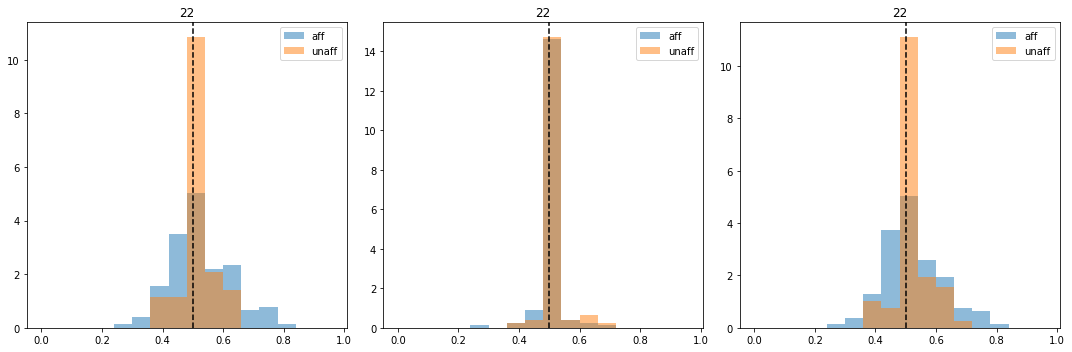

In [292]:
plt.figure(figsize=(15, 5))

deletion_to_index = dict([(x.deletion, j) for j, x in enumerate(collections)])

plt.subplot(1, 3, 1)
plt.hist(transrates_ihart_aff[ind_indices], bins=np.arange(0, 1, 0.06), alpha=0.5, label='aff', density=True)
plt.hist(transrates_ihart_unaff[ind_indices], bins=np.arange(0, 1, 0.06), alpha=0.5, label='unaff', density=True)

plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title(chrom)

plt.subplot(1, 3, 2)
plt.hist(transrates_ssc_aff[ind_indices], bins=np.arange(0, 1, 0.06), alpha=0.5, label='aff', density=True)
plt.hist(transrates_ssc_unaff[ind_indices], bins=np.arange(0, 1, 0.06), alpha=0.5, label='unaff', density=True)

plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title(chrom)

plt.subplot(1, 3, 3)
plt.hist(transrates_both_aff[ind_indices], bins=np.arange(0, 1, 0.06), alpha=0.5, label='aff', density=True)
plt.hist(transrates_both_unaff[ind_indices], bins=np.arange(0, 1, 0.06), alpha=0.5, label='unaff', density=True)

plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title(chrom)
    
plt.tight_layout()
plt.show()

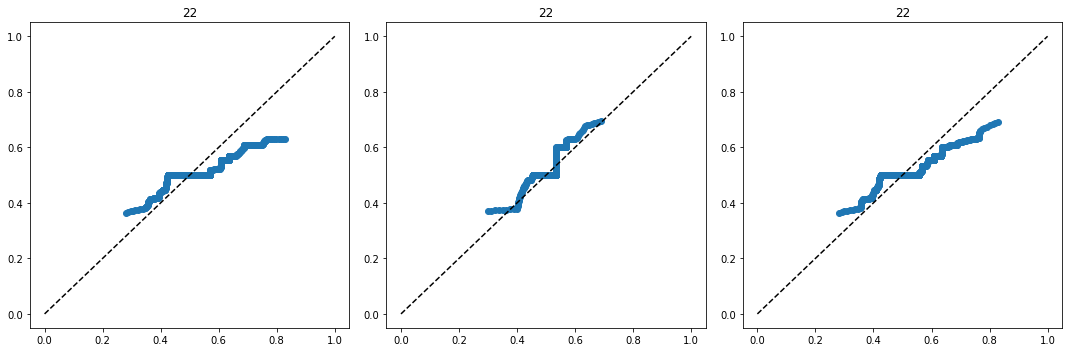

In [293]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(np.nanquantile(transrates_ihart_aff[ind_indices], np.arange(0, 1, 0.001)),
           np.nanquantile(transrates_ihart_unaff[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title(chrom)

plt.subplot(1, 3, 2)
plt.scatter(np.nanquantile(transrates_ssc_aff[ind_indices], np.arange(0, 1, 0.001)),
           np.nanquantile(transrates_ssc_unaff[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title(chrom)

plt.subplot(1, 3, 3)
plt.scatter(np.nanquantile(transrates_both_aff[ind_indices], np.arange(0, 1, 0.001)),
           np.nanquantile(transrates_both_unaff[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title(chrom)
    
plt.tight_layout()
plt.show()

In [299]:
print(scipy.stats.ttest_rel(transrates_ihart_aff, transrates_ihart_unaff))
print(scipy.stats.ttest_rel(transrates_ssc_aff, transrates_ssc_unaff))
print(scipy.stats.ttest_rel(transrates_both_aff, transrates_both_unaff))
print()

print(scipy.stats.ttest_rel(transrates_ihart_aff[ind_indices], transrates_ihart_unaff[ind_indices]))
print(scipy.stats.ttest_rel(transrates_ssc_aff[ind_indices], transrates_ssc_unaff[ind_indices]))
print(scipy.stats.ttest_rel(transrates_both_aff[ind_indices], transrates_both_unaff[ind_indices]))
print()

print(scipy.stats.ks_2samp(transrates_ihart_aff, transrates_ihart_unaff))
print(scipy.stats.ks_2samp(transrates_ssc_aff, transrates_ssc_unaff))
print(scipy.stats.ks_2samp(transrates_both_aff, transrates_both_unaff))
print()

print(scipy.stats.ks_2samp(transrates_ihart_aff[ind_indices], transrates_ihart_unaff[ind_indices]))
print(scipy.stats.ks_2samp(transrates_ssc_aff[ind_indices], transrates_ssc_unaff[ind_indices]))
print(scipy.stats.ks_2samp(transrates_both_aff[ind_indices], transrates_both_unaff[ind_indices]))
print()

up, down = np.sum(transrates_ihart_aff[ind_indices]>0.5), np.sum(transrates_ihart_aff[ind_indices]<0.5)
print(up, down)
print(scipy.stats.binom_test(up, up+down))
up, down = np.sum(transrates_ihart_unaff[ind_indices]>0.5), np.sum(transrates_ihart_unaff[ind_indices]<0.5)
print(up, down)
print(scipy.stats.binom_test(up, up+down))

k, n = np.sum(transrates_ssc_aff[ind_indices]>0.5), np.sum(transrates_ssc_aff[ind_indices]!=0.5)
print(k, n)
print(scipy.stats.binom_test(k, n))
k, n = np.sum(transrates_ssc_unaff[ind_indices]>0.5), np.sum(transrates_ssc_unaff[ind_indices]!=0.5)
print(k, n)
print(scipy.stats.binom_test(k, n))

k, n = np.sum(transrates_both_aff[ind_indices]>0.5), np.sum(transrates_both_aff[ind_indices]!=0.5)
print(k, n)
print(scipy.stats.binom_test(k, n))
k, n = np.sum(transrates_both_unaff[ind_indices]>0.5), np.sum(transrates_both_unaff[ind_indices]!=0.5)
print(k, n)
print(scipy.stats.binom_test(k, n))



Ttest_relResult(statistic=4.485918580967472, pvalue=9.82683049338439e-06)
Ttest_relResult(statistic=-5.276816292894958, pvalue=2.296028677214815e-07)
Ttest_relResult(statistic=1.892320031933692, pvalue=0.05926407278733373)

Ttest_relResult(statistic=1.553733319324243, pvalue=0.12271712837621261)
Ttest_relResult(statistic=-0.7240907696404072, pvalue=0.4703313706623853)
Ttest_relResult(statistic=1.1858397735564408, pvalue=0.23788223006589734)

Ks_2sampResult(statistic=0.22253521126760561, pvalue=3.2983909643979536e-08)
Ks_2sampResult(statistic=0.16619718309859155, pvalue=9.122438860438716e-05)
Ks_2sampResult(statistic=0.17183098591549295, pvalue=4.579554555588686e-05)

Ks_2sampResult(statistic=0.22480620155038755, pvalue=0.0023694489324309165)
Ks_2sampResult(statistic=0.07751937984496127, pvalue=0.8179072077933454)
Ks_2sampResult(statistic=0.24806201550387597, pvalue=0.0005468548375096859)

61 44
0.11799998150585823
32 19
0.09191454981585424
33 43
0.000606106631266812
23 30
0.00522287935

In [297]:
print(transrates_ihart_aff[ind_indices])

[0.54109966 0.56868761 0.46681338 0.45432909 0.6319086  0.42734034
 0.51110913 0.45432909 0.5        0.37974683 0.56868761 0.50438208
 0.41393354 0.5        0.55589516 0.46548799 0.68742708 0.50972109
 0.5        0.5        0.5        0.5        0.56942687 0.5
 0.6880977  0.5        0.5        0.42651627 0.41900672 0.46548799
 0.42035452 0.42279457 0.5        0.511567   0.5        0.44467803
 0.67085707 0.5        0.42651627 0.60912757 0.5        0.63553168
 0.43630653 0.7645747  0.63553168 0.46548799 0.60268023 0.36509577
 0.562906   0.63553168 0.5        0.56868761 0.69935831 0.52330366
 0.53422676 0.72956853 0.37962168 0.55589516 0.39390562 0.51265965
 0.56868761 0.56868761 0.40792135 0.60912757 0.34417592 0.54418093
 0.56868761 0.5        0.60912757 0.5        0.63553168 0.39322436
 0.47401285 0.46894299 0.46548799 0.40818938 0.51265965 0.47332269
 0.46548799 0.53422676 0.77660227 0.5        0.5        0.60912757
 0.63148165 0.60912757 0.53731762 0.57007717 0.5        0.75020073
 0

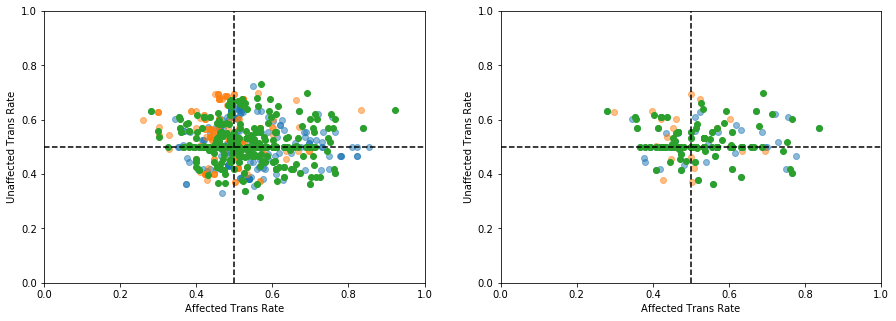

In [300]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(transrates_ihart_aff, transrates_ihart_unaff, alpha=0.5)
plt.scatter(transrates_ssc_aff, transrates_ssc_unaff, alpha=0.5)
plt.scatter(transrates_both_aff, transrates_both_unaff)
plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.subplot(1, 2, 2)
plt.scatter(transrates_ihart_aff[ind_indices], transrates_ihart_unaff[ind_indices], alpha=0.5)
plt.scatter(transrates_ssc_aff[ind_indices], transrates_ssc_unaff[ind_indices], alpha=0.5)
plt.scatter(transrates_both_aff[ind_indices], transrates_both_unaff[ind_indices])
plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [267]:
importlib.reload(btr)

#ihart
posteriors_ihart_aff = btr.calculate_posteriors(contingency_ihart_aff, ihart_family_sizes)
posteriors_ihart_unaff = btr.calculate_posteriors(contingency_ihart_unaff, ihart_family_sizes)

#ssc
posteriors_ssc_aff = btr.calculate_posteriors(contingency_ssc_aff, ihart_family_sizes)
posteriors_ssc_unaff = btr.calculate_posteriors(contingency_ssc_unaff, ihart_family_sizes)

#both
posteriors_both_aff = btr.calculate_posteriors(contingency_both_aff, ihart_family_sizes)
posteriors_both_unaff = btr.calculate_posteriors(contingency_both_unaff, ihart_family_sizes)


In [268]:
importlib.reload(btr)

overlap_ihart = btr.calculate_posterior_overlap(posteriors_ihart_aff, posteriors_ihart_unaff)
print(np.min(overlap_ihart))

overlap_ssc = btr.calculate_posterior_overlap(posteriors_ssc_aff, posteriors_ssc_unaff)
print(np.min(overlap_ssc))

overlap_both = btr.calculate_posterior_overlap(posteriors_both_aff, posteriors_both_unaff)
print(np.min(overlap_both))



0.1396161997944131
0.2467473804202764
0.09194045006655199


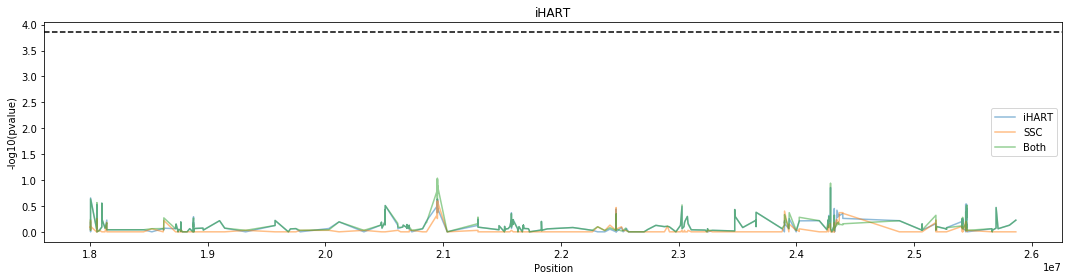

In [269]:
plt.figure(figsize=(15, 4))
 
cutoff = -np.log10(0.05/len(collections))

plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('iHART')

positions = np.array([c.deletion.start_pos for c in collections])
plt.plot(positions, -np.log10(overlap_ihart),label='iHART', alpha=0.5)
plt.plot(positions, -np.log10(overlap_ssc),label='SSC', alpha=0.5)
plt.plot(positions, -np.log10(overlap_both),label='Both', alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

In [270]:
#ihart
posterior_pvalues_ihart_aff = btr.calculate_posterior_pvalue(posteriors_ihart_aff)
posterior_pvalues_ihart_unaff =  btr.calculate_posterior_pvalue(posteriors_ihart_unaff)

#ssc
posterior_pvalues_ssc_aff =  btr.calculate_posterior_pvalue(posteriors_ssc_aff)
posterior_pvalues_ssc_unaff =  btr.calculate_posterior_pvalue(posteriors_ssc_unaff)

#both
posterior_pvalues_both_aff =  btr.calculate_posterior_pvalue(posteriors_both_aff)
posterior_pvalues_both_unaff =  btr.calculate_posterior_pvalue(posteriors_both_unaff)


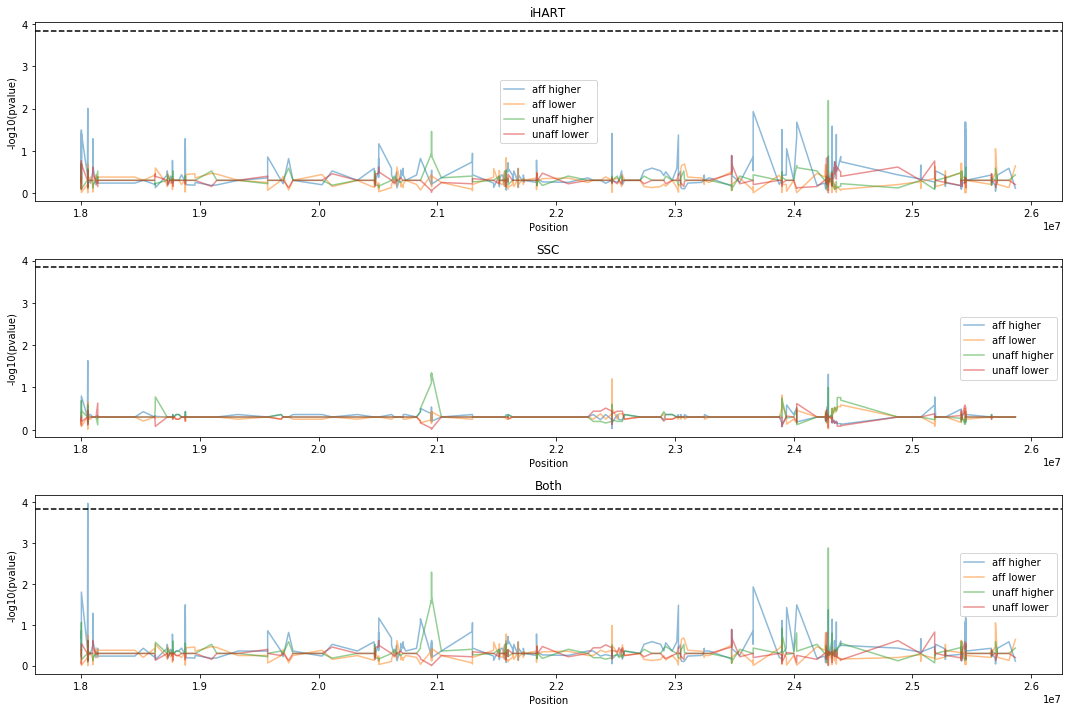

In [271]:
plt.figure(figsize=(15, 10))
 
cutoff = -np.log10(0.05/len(contingency_both_aff))
#cutoff = -np.log10(0.05/len(all_collections))

positions = np.array([c.deletion.start_pos for c in collections])
plt.subplot(3, 1, 1)
plt.plot(positions, -np.log10(posterior_pvalues_ihart_aff[:, 0]), label='aff higher', alpha=0.5)
plt.plot(positions, -np.log10(posterior_pvalues_ihart_aff[:, 1]), label='aff lower', alpha=0.5)
plt.plot(positions, -np.log10(posterior_pvalues_ihart_unaff[:, 0]), label='unaff higher', alpha=0.5)
plt.plot(positions, -np.log10(posterior_pvalues_ihart_unaff[:, 1]), label='unaff lower', alpha=0.5)
plt.subplot(3, 1, 2)
plt.plot(positions, -np.log10(posterior_pvalues_ssc_aff[:, 0]), label='aff higher', alpha=0.5)
plt.plot(positions, -np.log10(posterior_pvalues_ssc_aff[:, 1]), label='aff lower', alpha=0.5)
plt.plot(positions, -np.log10(posterior_pvalues_ssc_unaff[:, 0]), label='unaff higher', alpha=0.5)
plt.plot(positions, -np.log10(posterior_pvalues_ssc_unaff[:, 1]), label='unaff lower', alpha=0.5)
plt.subplot(3, 1, 3)
plt.plot(positions, -np.log10(posterior_pvalues_both_aff[:, 0]), label='aff higher', alpha=0.5)
plt.plot(positions, -np.log10(posterior_pvalues_both_aff[:, 1]), label='aff lower', alpha=0.5)
plt.plot(positions, -np.log10(posterior_pvalues_both_unaff[:, 0]), label='unaff higher', alpha=0.5)
plt.plot(positions, -np.log10(posterior_pvalues_both_unaff[:, 1]), label='unaff lower', alpha=0.5)

titles = ['iHART', 'SSC', 'Both']
for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.axhline(cutoff, linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    plt.title(title)
    plt.legend()
    
plt.tight_layout()
plt.show()

In [272]:
print(cutoff)
for j in np.where(-np.log10(posterior_pvalues_both_aff[:, 0]) > cutoff)[0]:
    d = collections[j].deletion
    print('%s%s:%d-%d %d %d %0.2f %0.2f' % ('*' if ind_indices[j] else '', 
                                       d.chrom, d.opt_start_pos, d.opt_end_pos, d.length, 
                                          j, -np.log10(posterior_pvalues_both_aff[j, 0]),
                                      -np.log10(posterior_pvalues_both_unaff[j, 0])))
    print(np.hstack((contingency_ihart_aff[j], contingency_ssc_aff[j])))
    print(np.hstack((contingency_ihart_unaff[j], contingency_ssc_unaff[j])))
    
    

3.8512583487190755
22:18057363-18061336 3974 16 3.98 0.59
[[ 0.  1.  0.  0.]
 [ 0. 12.  0. 13.]
 [ 0.  0.  0.  0.]
 [ 0.  2.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


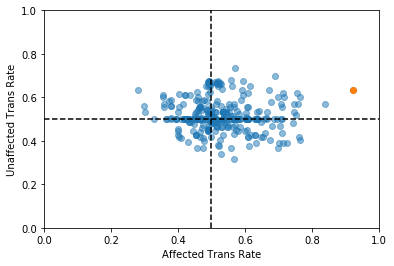

In [273]:
plt.scatter(transrates_both_aff, transrates_both_unaff, alpha=0.5)
plt.scatter(transrates_both_aff[np.any(-np.log10(posterior_pvalues_both_aff)>cutoff, axis=1)], 
            transrates_both_unaff[np.any(-np.log10(posterior_pvalues_both_aff)>cutoff, axis=1)])
plt.scatter(transrates_both_aff[np.any(-np.log10(posterior_pvalues_both_unaff)>cutoff, axis=1)], 
            transrates_both_unaff[np.any(-np.log10(posterior_pvalues_both_unaff)>cutoff, axis=1)])

plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()